In [3]:
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams["font.family"] = "Arial"
import scipy.interpolate as interp
import time
from tqdm import tqdm
from IPython import display
import scipy.optimize as opt
import scipy.signal as sgnl
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.special import gamma

from scipy.io import savemat, loadmat

# Local application/library specific imports
from kan import *
import use_KAN
# from use_KAN import *

from use_training_set import *
import yaml

# device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# print(device)
cpu = torch.device('cpu')
device = cpu
torch.set_default_dtype(torch.float32)

parameters mean: [ 0.24268419  0.25925395 13.01958803]
parameters std: [0.11136719 0.13834257 6.95043716]
parameters shape: (8486, 3)
SQ shape: (8486, 95)
Q shape: (95,)
Outliers are at indices: (array([2409]), array([0]))


In [4]:
def f_SQ_KAN(model, x, Q=Q, device=device):
    # Extract phi from x
    phi = x[:, 0]*1
    
    # Transform x using kan_aug
    n_data = x.shape[0]
    x = x.view(-1, 3)
    x_transformed = model.kan_aug(x)
    
    # Transform Q using to_torch_device
    Q_torch = to_torch_device(Q)
    Q_torch_scale = to_torch_device((Q - 6) / 20)
    
    # Expand dimensions to match Q_torch
    x_expanded = x_transformed.unsqueeze(1).expand(-1, Q_torch_scale.size(0), -1)
    Q_expanded = Q_torch_scale.unsqueeze(0).unsqueeze(-1).expand(x.size(0), -1, x.size(-1))
    
    # Combine Q and x
    Q_params = torch.cat([Q_expanded, x_expanded], dim=-1)
    Q_params_reshaped = Q_params.view(-1, Q_params.size(-1))
    
    # Produce G(Q, x) using kan
    G_full = model.kan(Q_params_reshaped)
    G_full_reshaped = G_full.view(x_transformed.size(0), Q_torch_scale.size(0), 3)  # (n_data, n_Q, 3)
    
     # Extract outputs
    output_1 = G_full_reshaped[:, :, 0]
    output_2 = G_full_reshaped[:, :, 1]
    output_3 = G_full_reshaped[:, :, 2]
    
    # Compute G_HS_bias
    G_HS_bias = (model.multiplier * output_1 * torch.sin(output_2)) / Q_torch
    
    # Expand phi to match output_1
    phi_expanded = phi.unsqueeze(1).expand_as(output_1)
    
    # Compute alpha, beta, and gama
    alpha = (1 + 2 * phi)**2 / (1 - phi)**4
    beta = -6 * phi * (1 + phi / 2)**2 / (1 - phi)**4
    gama = phi * alpha / 2
    
    # Compute G_hs(Q, phi)
    Q_torch = Q_torch.unsqueeze(0).expand(x.size(0), -1)
    alpha_expanded = alpha.unsqueeze(1).expand_as(Q_torch)
    beta_expanded = beta.unsqueeze(1).expand_as(Q_torch)
    gama_expanded = gama.unsqueeze(1).expand_as(Q_torch)
    
    G_hs = (alpha_expanded * (torch.sin(Q_torch) - Q_torch * torch.cos(Q_torch)) / Q_torch**2 +
            beta_expanded * (2 * Q_torch * torch.sin(Q_torch) + (2 - Q_torch**2) * torch.cos(Q_torch) - 2) / Q_torch**3 +
            gama_expanded * (-Q_torch**4 * torch.cos(Q_torch) + 4 * ((3 * Q_torch**2 - 6) * torch.cos(Q_torch) +
            (Q_torch**3 - 6 * Q_torch) * torch.sin(Q_torch) + 6)) / Q_torch**5)
    
    # Ensure G_hs has the shape (n_sample, n_Q)
    G_hs = G_hs.view(x.size(0), Q_torch.size(1))
    
    S_hs = 1 / (24 * phi_expanded * (G_hs + G_HS_bias) / Q_torch + 1 + output_3)
    
    return S_hs

lf_SQ_KAN = lambda x, Q: f_SQ_KAN(model_KAN, x, Q, device=device)

def err_L2(x,y):
    index_loss = np.random.randint(95, size=76)
    return np.mean((x[index_loss]-y[index_loss])**2)

In [5]:
def unpack_data(data):
    Q = data['Q'][0]
    IQ_I = data['IQ_I'][0]
    IQ_er_I = data['IQ_er_I'][0]
    sigma = data['sigma'][0]
    fp = data['fp'][0]
    fp_std = data['fp_std'][0]
    fp_Z = data['fp_Z'][0]
    fp_std_Z = data['fp_std_Z'][0]
    IQ_fit = data['IQ_fit'][0]
    v = data['v']
    
    return Q, IQ_I, IQ_er_I, IQ_fit, sigma, fp, fp_std, fp_Z, fp_std_Z, v
    
rr = np.linspace(0.01, 10.0, 200)
ur_hc = 4*500*((2**(1/6)/rr)**12-(2**(1/6)/rr)**6-0.25)
ur_hc[rr>=1] = 0

def sd_exp_x(mu_x, sigma_x):
    """
    Calculate the standard deviation of exp(x) where x is normally distributed.
    
    Parameters:
    - mu_x: Mean of x
    - sigma_x: Standard deviation of x
    
    Returns:
    - Standard deviation of exp(x)
    """
    # Calculate the expected value of exp(2x) and exp(x)
    exp_2x = np.exp(2 * mu_x + 2 * sigma_x**2)
    exp_x = np.exp(mu_x + 0.5 * sigma_x**2)
    
    # Variance of exp(x)
    var_exp_x = exp_2x - exp_x**2
    
    # Standard deviation is the square root of the variance
    return np.sqrt(var_exp_x)

def sample_potential(fp,fp_err):
    n_sample = 100
    
    kappa = fp[1]
    kappa_std = fp_err[1]
    A = np.exp(fp[2])
    A_std = sd_exp_x(fp[2], fp_err[2])
    
    ur_sample = np.zeros((len(rr),n_sample))
    for i in range(n_sample):
        kappa_sample = np.random.normal()*(kappa_std) + kappa
        A_sample = np.random.normal()*(A_std) + A
        ur_sample[:,i] = A_sample*np.exp(-(rr-1)/kappa_sample)/rr + ur_hc
        
    ur_std = np.std(ur_sample,axis=1)
    ur_mean = np.mean(ur_sample,axis=1)
        
    return ur_mean, ur_std

def sample_potential_GT(fp):
    kappa = fp[1]
    A = fp[2]
    
    ur = A*np.exp(-(rr-1)/kappa)/rr + ur_hc
        
    return ur

In [24]:
"""
SOLARIZED HEX     16/8 TERMCOL  XTERM/HEX   L*A*B      RGB         HSB
--------- ------- ---- -------  ----------- ---------- ----------- -----------
base03    #002b36  8/4 brblack  234 #1c1c1c 15 -12 -12   0  43  54 193 100  21
base02    #073642  0/4 black    235 #262626 20 -12 -12   7  54  66 192  90  26
base01    #586e75 10/7 brgreen  240 #585858 45 -07 -07  88 110 117 194  25  46
base00    #657b83 11/7 bryellow 241 #626262 50 -07 -07 101 123 131 195  23  51
base0     #839496 12/6 brblue   244 #808080 60 -06 -03 131 148 150 186  13  59
base1     #93a1a1 14/4 brcyan   245 #8a8a8a 65 -05 -02 147 161 161 180   9  63
base2     #eee8d5  7/7 white    254 #e4e4e4 92 -00  10 238 232 213  44  11  93
base3     #fdf6e3 15/7 brwhite  230 #ffffd7 97  00  10 253 246 227  44  10  99
yellow    #b58900  3/3 yellow   136 #af8700 60  10  65 181 137   0  45 100  71
orange    #cb4b16  9/3 brred    166 #d75f00 50  50  55 203  75  22  18  89  80
red       #dc322f  1/1 red      160 #d70000 50  65  45 220  50  47   1  79  86
magenta   #d33682  5/5 magenta  125 #af005f 50  65 -05 211  54 130 331  74  83
violet    #6c71c4 13/5 brmagenta 61 #5f5faf 50  15 -45 108 113 196 237  45  77
blue      #268bd2  4/4 blue      33 #0087ff 55 -10 -45  38 139 210 205  82  82
cyan      #2aa198  6/6 cyan      37 #00afaf 60 -35 -05  42 161 152 175  74  63
green     #859900  2/2 green     64 #5f8700 60 -20  65 133 153   0  68 100  60
"""
solarized_base03 = "#002b36"
solarized_base02 = "#073642"
solarized_base01 = "#586e75"
solarized_base00 = "#657b83"
solarized_base0 = "#839496"
solarized_base1 = "#93a1a1"
solarized_base2 = "#eee8d5"
solarized_base3 = "#fdf6e3"
solarized_yellow = "#b58900"
solarized_orange = "#cb4b16"
solarized_red = "#dc322f"
solarized_magenta = "#d33682"
solarized_violet = "#6c71c4"
solarized_blue = "#268bd2"
solarized_cyan = "#2aa198"
solarized_green = "#859900"

color_list = [solarized_red, solarized_blue, solarized_cyan, solarized_violet]

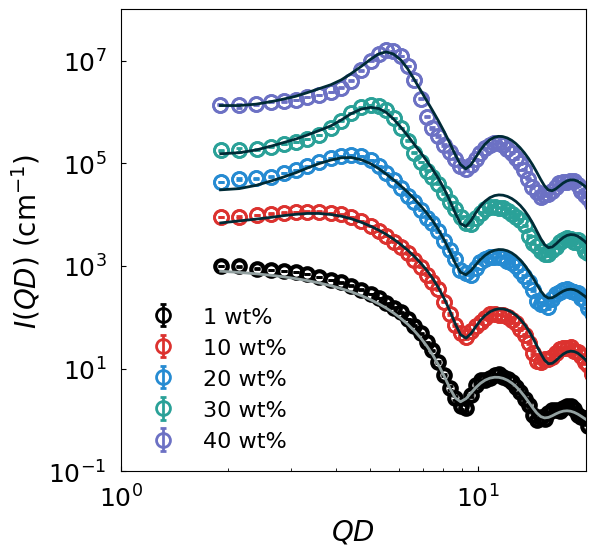

In [55]:
color_list = [solarized_red, solarized_blue, solarized_cyan, solarized_violet]
W_list = [10,20,30,40]

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

# 1%
data = loadmat('results_10.mat')
Q, IQ_I, IQ_er_I, IQ_fit, sigma, fp, fp_std, fp_Z, fp_std_Z, v = unpack_data(data)
IQ_P = data['IQ_P'][0]
IQ_er_P = data['IQ_er_P'][0]
IQ_fit_P = data['IQ_fit_P'][0]
I_inc = v['I_inc'][0][0][0][0]
ax.plot(Q*sigma*1e10,IQ_P,'o',color='k',fillstyle='none',ms=8, markeredgewidth=2, lw=2)
ax.errorbar(Q*sigma*1e10,IQ_P,IQ_er_P,label='1 wt%',
            linestyle='',fmt='o',color='k',capsize=2,fillstyle='none',ms=10, markeredgewidth=2, lw=2)
ax.plot(Q*sigma*1e10, IQ_fit_P+I_inc,'-',color=solarized_base1, markeredgewidth=2, lw=2, zorder=20)

# 10% to 40%
for i, W in enumerate(W_list):
    filename = 'results_{}.mat'.format(W)
    data = loadmat(filename)
    Q, IQ_I, IQ_er_I, IQ_fit, sigma, fp, fp_std, fp_Z, fp_std_Z, v = unpack_data(data)
    
    I_inc = v['I_inc'][0][0][0][0]
    
    ax.plot(Q*sigma*1e10,(IQ_I)*10**i*5,'o',color=color_list[i],fillstyle='none',ms=10, markeredgewidth=2)
    ax.errorbar(Q*sigma*1e10,(IQ_I)*10**i*5,IQ_er_I*10**i*5,label='{} wt%'.format(W),
                linestyle='',fmt='o',color=color_list[i],capsize=2,fillstyle='none',ms=10, markeredgewidth=2, lw=2)

    ax.plot(Q*sigma*1e10, (IQ_fit+I_inc)*10**i*5,'-',color=solarized_base03, lw=2, zorder=20)

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim([1,20])
ax.set_ylim([1e-1,1e8])
ax.set_xlabel(r'$QD$',fontsize=20)
ax.set_ylabel(r'$I(QD)\ (\mathrm{cm^{-1}})$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.legend(fontsize=16,frameon=False)

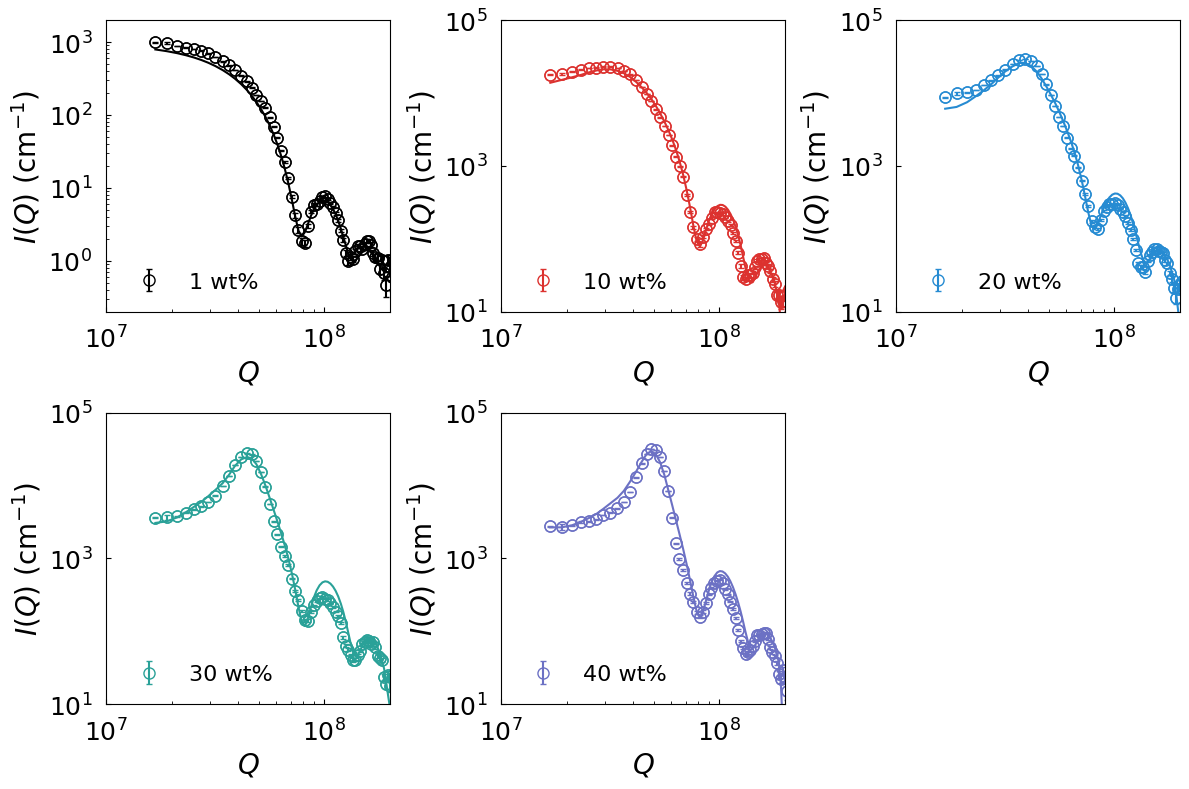

In [26]:
W_list = [10,20,30,40]

fig = plt.figure(figsize=(12, 8))
# color_list = ['C0','C1','C2','C3','C4']

# 1%
ax = plt.subplot(2, 3, 1)
data = loadmat('results_10.mat')
Q, IQ_I, IQ_er_I, IQ_fit, sigma, fp, fp_std, fp_Z, fp_std_Z, v = unpack_data(data)
IQ_P = data['IQ_P'][0]
IQ_er_P = data['IQ_er_P'][0]
IQ_fit_P = data['IQ_fit_P'][0]
ax.plot(Q*1e10,IQ_P,'o',color='k',fillstyle='none',ms=8)
ax.errorbar(Q*1e10,IQ_P,IQ_er_P,label='1 wt%',
            linestyle='',fmt='o',color='k',capsize=2,fillstyle='none',ms=8)
ax.plot(Q*1e10, IQ_fit_P,'-',color='k')

ax.set_yscale('log')
ax.set_xscale('log')

ax.set_xlim([1*1e7,20*1e7])
ax.set_ylim([2e-1,2e3])
ax.set_xlabel(r'$Q$',fontsize=20)
ax.set_ylabel(r'$I(Q)\ (\mathrm{cm^{-1}})$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
ax.legend(fontsize=16,frameon=False)

# 10% to 40%
for i, W in enumerate(W_list):
    ax = plt.subplot(2, 3, i+2)
    filename = 'results_{}.mat'.format(W)
    data = loadmat(filename)
    Q, IQ_I, IQ_er_I, IQ_fit, sigma, fp, fp_std, fp_Z, fp_std_Z, v = unpack_data(data)
    
    I_inc = v['I_inc'][0][0][0][0]

    ax.plot(Q*1e10,(IQ_I+I_inc)*10,'o',color=color_list[i],fillstyle='none',ms=8)
    ax.errorbar(Q*1e10,(IQ_I+I_inc)*10,IQ_er_I*10,label='{} wt%'.format(W),
                linestyle='',fmt='o',color=color_list[i],capsize=2,fillstyle='none',ms=8)

    ax.plot(Q*1e10, (IQ_fit+I_inc)*10,'-',color=color_list[i])

    ax.set_yscale('log')
    ax.set_xscale('log')

    ax.set_xlim([1*1e7,20*1e7])
    ax.set_ylim([1e1,1e5])
    ax.set_xlabel(r'$Q$',fontsize=20)
    ax.set_ylabel(r'$I(Q)\ (\mathrm{cm^{-1}})$',fontsize=20)
    ax.tick_params(direction='in', axis='both', which='both', labelsize=18, pad=10)
    ax.legend(fontsize=16,frameon=False)

plt.tight_layout()

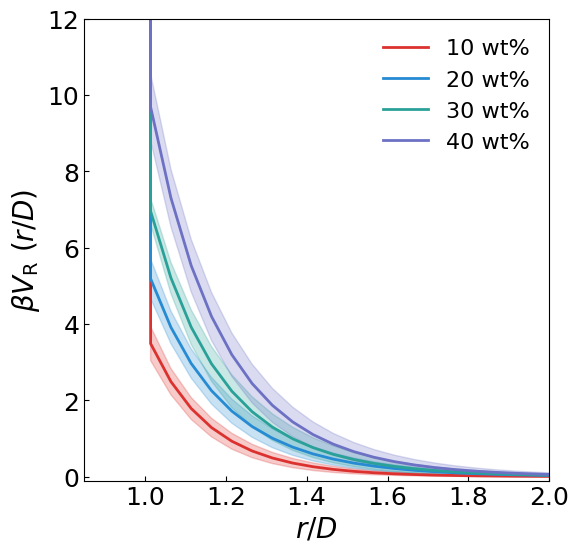

In [48]:
W_list = [10,20,30,40]

fig = plt.figure(figsize=(6, 6))
ax = plt.subplot(1, 1, 1)

# color_list = ['C0','C1','C2','C3','C4']

for i, W in enumerate(W_list):
    filename = 'results_{}.mat'.format(W)
    data = loadmat(filename)
    Q, IQ_I, IQ_er_I, IQ_fit, sigma, fp, fp_std, fp_Z, fp_std_Z, v = unpack_data(data)
    
    ur_NN, ur_NN_std = sample_potential(fp,fp_std)
    
    ax.fill_between(rr,ur_NN+ur_NN_std,ur_NN-ur_NN_std,
                    color=color_list[i],alpha=0.25)
    ax.plot(rr,ur_NN,color=color_list[i],label='{} wt%'.format(W), lw=2)

ax.set_xlim(0.85,2.0)
ax.set_ylim(-0.1,12)
ax.set_xlabel(r'$r/D$',fontsize=20)
ax.set_ylabel(r'$\beta V_\mathrm{R}\ (r/D)$',fontsize=20)
ax.tick_params(direction='in', axis='both', which='both', labelsize=18)
ax.legend(fontsize=16,frameon=False)

In [28]:
## make table
def print_table(data,W):
    Q, IQ_I, IQ_er_I, IQ_fit, sigma, fp, fp_std, fp_Z, fp_std_Z, v = unpack_data(data)

    index_print = [0,1,2]
    string_NN = ''
    for j in index_print:
        string_NN += '{:0.4f}$\pm${:0.4f}'.format(fp[j],fp_std[j])
        if j<3:
            string_NN += ' & '
    string_NN += '{:0.4f}$\pm${:0.4f}'.format(fp_Z[0],fp_std_Z[0])
    string_W = '{} wt\% & '.format(W)
    string_row = string_W + string_NN+r'\\'
    print(string_row)

print(r'\begin{tabular}{ccccc}')
print('\hline')
print('\hline')
print(r' & $\phi$ & $1/\kappa D$ & $AD$ & $Z$\\')
for i, W in enumerate(W_list):
    filename = 'results_{}.mat'.format(W)
    data = loadmat(filename)
    print('\hline')
    print_table(data,W)
print('\hline')
print('\end{tabular}')

\begin{tabular}{ccccc}
\hline
\hline
 & $\phi$ & $1/\kappa D$ & $AD$ & $Z$\\
\hline
10 wt\% & 0.0812$\pm$0.0003 & 0.1791$\pm$0.0260 & 1.3476$\pm$0.1143 & 20.3052$\pm$2.1903\\
\hline
20 wt\% & 0.1500$\pm$0.0000 & 0.2207$\pm$0.0374 & 1.7181$\pm$0.0959 & 21.0403$\pm$2.4782\\
\hline
30 wt\% & 0.2313$\pm$0.0000 & 0.2112$\pm$0.0345 & 2.0163$\pm$0.0500 & 25.1855$\pm$2.8879\\
\hline
40 wt\% & 0.2941$\pm$0.0000 & 0.2149$\pm$0.0349 & 2.3452$\pm$0.0805 & 29.3331$\pm$3.3290\\
\hline
\end{tabular}
